### Pruning Algorithm for Loss Landscapes

This algorithm aims to find a minimal subset of loss landscapes that can accurately represent the average behavior of the full dataset. Here's how it works:

1. Data Preparation & Full Average
   - Input: M loss landscapes of size n x n x 1 
   - Compute the full dataset average by:
     a) Taking mean across all M samples
     b) Applying log transform to the mean
   - This gives us our target "true" average landscape L_full

2. Clustering Setup
   - Reshape each n x n x 1 landscape into a 1D vector of length n*n
   - If n_clusters not specified:
     a) Use silhouette score to automatically select optimal cluster count
     b) Try cluster counts from 2 up to min(10, M-1)
     c) Pick cluster count with highest silhouette score

3. Initial Subset Selection
   - Perform k-means clustering with chosen n_clusters
   - For each cluster:
     a) Find the centroid
     b) Select the sample closest to centroid as representative (either euclidean distance or cosine similarity)
   - This gives initial subset of size n_clusters

4. Iterative Refinement
   - While MAE > threshold and iterations < max_iters:
     a) For each cluster:
        - Try adding each unselected member to current subset
        - Compute new average and MAE
        - Track best improvement in MAE
     b) If no improvement possible, stop
     c) Otherwise, add best candidate to subset
     d) Update approximation and MAE

5. Output
   - Selected indices of representative samples
   - Original full average landscape
   - Final approximated average landscape 
   - Final MAE between true and approximated averages
   - Number of clusters used

Key Features:
- Automatic cluster count selection using silhouette score
- Log transform to handle multiplicative relationships
- Iterative refinement to minimize error
- Early stopping when no further improvement possible
- Flexible MAE threshold for accuracy control

The algorithm balances computational efficiency with accuracy by:
1. Using clustering to identify natural groupings
2. Starting with minimal representatives
3. Incrementally adding samples for better accuracy
4. Stopping when desired accuracy reached


In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import sys
os.chdir('..')

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed to 'ensure_all_finite'")

Testing on iteration 1 training set.

In [3]:
folder_path = os.path.join('computed_loss_landscapes','self_train_data_ON_EIGVEC_iter_1_self_train_250_lowest_error')

Loading data

In [4]:
with open(os.path.join(folder_path, 'processed_loss_function_dict.pkl'), 'rb') as file:
    loss_function_dict = pickle.load(file)

with open(os.path.join(folder_path, 'feat_sample_df.pkl'), 'rb') as file:
    feat_sample_df = pickle.load(file)

with open(os.path.join(folder_path, 'feat_sample_composition_df.pkl'), 'rb') as file:
    feat_sample_composition_df = pickle.load(file)

with open(os.path.join(folder_path, 'feat_sample_structure_df.pkl'), 'rb') as file:
    feat_sample_structure_df = pickle.load(file)

sample_dict = {
    'feat_sample_df': feat_sample_df,
    'feat_sample_composition_df': feat_sample_composition_df,
    'feat_sample_structure_df': feat_sample_structure_df}

combined_dict = {**sample_dict, **loss_function_dict}

Define key function

In [5]:
def select_optimal_clusters(X, k_min=2, k_max=None, random_state=0):
    """
    Choose the best number of clusters for KMeans using silhouette score.
    
    Args:
        X            : np.ndarray of shape (M, features)
        k_min        : int, minimum number of clusters to try (>=2)
        k_max        : int or None, maximum number of clusters to try;
                       if None, uses min(10, M-1)
        random_state : int, random seed for reproducibility
    
    Returns:
        best_k       : int, the number of clusters with highest silhouette score
    """
    M = X.shape[0]
    if k_max is None:
        k_max = min(10, M - 1)
    best_score = -1
    best_k = k_min
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, random_state=random_state).fit(X)
        labels = km.labels_
        # silhouette_score requires at least 2 clusters and fewer than M clusters
        if 1 < len(np.unique(labels)) < M:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score, best_k = score, k
    return best_k
def approximate_subset_auto_k(samples,
                              n_clusters=None,
                              mae_threshold=1e-3,
                              max_iters=1000,
                              random_state=0,
                              distance_metric='norm'):
    """
    Find a small subset whose average loss landscape approximates the full average
    within a given MAE tolerance, automatically choosing cluster count if desired.
    
    Args:
        samples        : np.ndarray of shape (M, n, n, 1)
        n_clusters     : int or None; if None, automatically selected via silhouette
        mae_threshold  : float, stopping criterion on mean absolute error
        max_iters      : int, maximum number of refinement iterations
        random_state   : int, seed for clustering
        distance_metric: str, either 'norm' or 'cosine' for centroid distance calculation
    
    Returns:
        selected_idxs  : set of indices into `samples` forming the chosen subset
        L_full         : np.ndarray, the true full-list average after log transform
        L_approx       : np.ndarray, the final subset-average approximation after log transform
        mae_val        : float, final MAE between L_approx and L_full
        used_k         : int, the number of clusters actually used
    """
    # 1. Compute the full-list average (average raw then log)
    L_full = np.log(samples.mean(axis=0))            # (n, n, 1)
    f_full = L_full.ravel()
    
    # 2. Flatten for clustering
    M, n, _, _ = samples.shape
    X = samples.reshape(M, -1)               # (M, n*n)
    
    # 3. Decide number of clusters if not provided
    if n_clusters is None:
        n_clusters = select_optimal_clusters(X, random_state=random_state)
        print(f"Automatically selected n_clusters = {n_clusters}")
    
    # 4. Cluster into n_clusters groups
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X)
    labels = kmeans.labels_
    
    # 5. Pick one representative per cluster (closest to centroid)
    selected_idxs = set()
    for k in range(n_clusters):
        members = np.where(labels == k)[0]
        centroid = kmeans.cluster_centers_[k]
        
        if distance_metric == 'norm':
            dists = np.linalg.norm(X[members] - centroid, axis=1)
            selected_idxs.add(members[np.argmin(dists)])
        elif distance_metric == 'cosine':
            # Compute cosine similarity (higher is better)
            similarities = np.sum(X[members] * centroid, axis=1) / (
                np.linalg.norm(X[members], axis=1) * np.linalg.norm(centroid)
            )
            selected_idxs.add(members[np.argmax(similarities)])
        else:
            raise ValueError("distance_metric must be either 'norm' or 'cosine'")
    
    # 6. Compute initial approximation and MAE (average raw then log)
    L_approx = np.log(samples[list(selected_idxs)].mean(axis=0))
    f_approx = L_approx.ravel()
    mae_val = np.mean(np.abs(f_full - f_approx))
    
    # 7. Iterative refinement to reduce MAE
    iters = 0
    while mae_val > mae_threshold and iters < max_iters:
        best_reduction = 0.0
        best_candidate = None
        
        for k in range(n_clusters):
            cluster_members = set(np.where(labels == k)[0])
            candidates = cluster_members - selected_idxs
            for c in candidates:
                trial_idxs = list(selected_idxs) + [c]
                # Average raw values then apply log
                L_trial = np.log(samples[trial_idxs].mean(axis=0)).ravel()
                trial_mae = np.mean(np.abs(f_full - L_trial))
                reduction = mae_val - trial_mae
                if reduction > best_reduction:
                    best_reduction, best_candidate = reduction, c
        
        if best_candidate is None:
            #print("No further improvement possible; stopping.")
            break
        
        selected_idxs.add(best_candidate)
        # Average raw values then apply log for final approximation
        L_approx = np.log(samples[list(selected_idxs)].mean(axis=0))
        f_approx = L_approx.ravel()
        mae_val = np.mean(np.abs(f_full - f_approx))
        iters += 1
    
    return selected_idxs, L_full, L_approx, mae_val, n_clusters
def approximate_subset_auto_k_pca(samples,
                              n_clusters=None,
                              mae_threshold=1e-3,
                              max_iters=1000,
                              random_state=0,
                              distance_metric='norm', n_components=0.999):
    """
    Find a small subset whose average loss landscape approximates the full average
    within a given MAE tolerance, automatically choosing cluster count if desired.
    
    Args:
        samples        : np.ndarray of shape (M, n, n, 1)
        n_clusters     : int or None; if None, automatically selected via silhouette
        mae_threshold  : float, stopping criterion on mean absolute error
        max_iters      : int, maximum number of refinement iterations
        random_state   : int, seed for clustering
        distance_metric: str, either 'norm' or 'cosine' for centroid distance calculation
    
    Returns:
        selected_idxs  : set of indices into `samples` forming the chosen subset
        L_full         : np.ndarray, the true full-list average after log transform
        L_approx       : np.ndarray, the final subset-average approximation after log transform
        mae_val        : float, final MAE between L_approx and L_full
        used_k         : int, the number of clusters actually used
    """
    # 1. Compute the full-list average (average raw then log)
    L_full = np.log(samples.mean(axis=0))            # (n, n, 1)
    f_full = L_full.ravel()
    
    # 2. Flatten for PCA
    M, n, _, _ = samples.shape
    X = samples.reshape(M, -1)               # (M, n*n)
    
    # Apply PCA
    pca = PCA(n_components=n_components)  # Keep 95% of variance
    X_pca = pca.fit_transform(X)
    #print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    #print(f'PCA components number: {pca.n_components_}')
    
    # 3. Decide number of clusters if not provided
    if n_clusters is None:
        n_clusters = select_optimal_clusters(X_pca, random_state=random_state)
        #print(f"Automatically selected n_clusters = {n_clusters}")
    
    # 4. Cluster into n_clusters groups using PCA-transformed data
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X_pca)
    labels = kmeans.labels_
    
    # 5. Pick one representative per cluster (closest to centroid in PCA space)
    selected_idxs = set()
    for k in range(n_clusters):
        members = np.where(labels == k)[0]
        centroid = kmeans.cluster_centers_[k]
        
        if distance_metric == 'norm':
            dists = np.linalg.norm(X_pca[members] - centroid, axis=1)
            selected_idxs.add(members[np.argmin(dists)])
        elif distance_metric == 'cosine':
            # Compute cosine similarity (higher is better)
            similarities = np.sum(X_pca[members] * centroid, axis=1) / (
                np.linalg.norm(X_pca[members], axis=1) * np.linalg.norm(centroid)
            )
            selected_idxs.add(members[np.argmax(similarities)])
        else:
            raise ValueError("distance_metric must be either 'norm' or 'cosine'")
    
    # 6. Compute initial approximation and MAE (average raw then log)
    L_approx = np.log(samples[list(selected_idxs)].mean(axis=0))
    f_approx = L_approx.ravel()
    mae_val = np.mean(np.abs(f_full - f_approx))
    
    # 7. Iterative refinement to reduce MAE
    iters = 0
    while mae_val > mae_threshold and iters < max_iters:
        best_reduction = 0.0
        best_candidate = None
        
        for k in range(n_clusters):
            cluster_members = set(np.where(labels == k)[0])
            candidates = cluster_members - selected_idxs
            for c in candidates:
                trial_idxs = list(selected_idxs) + [c]
                # Average raw values then apply log
                L_trial = np.log(samples[trial_idxs].mean(axis=0)).ravel()
                trial_mae = np.mean(np.abs(f_full - L_trial))
                reduction = mae_val - trial_mae
                if reduction > best_reduction:
                    best_reduction, best_candidate = reduction, c
        
        if best_candidate is None:
            #print("No further improvement possible; stopping.")
            break
        
        selected_idxs.add(best_candidate)
        # Average raw values then apply log for final approximation
        L_approx = np.log(samples[list(selected_idxs)].mean(axis=0))
        f_approx = L_approx.ravel()
        mae_val = np.mean(np.abs(f_full - f_approx))
        iters += 1
    
    return selected_idxs, L_full, L_approx, mae_val, n_clusters


The previous cell compares two approaches for approximating the subset:
1. Without PCA: Direct clustering on the raw loss landscape data
2. With PCA: Clustering on PCA-transformed data (retaining 99.9% variance)

The PCA approach reduces dimensionality while preserving most variance,
potentially improving clustering efficiency and reducing noise sensitivity


In [10]:
property_1 = combined_dict['feat_sample_df']['formula'].copy()
landscape_array_1 = loss_function_dict['train_630_data_ON_EIGVEC_iter_1_self_train_250_lowest_error_mse']['train_630_data_ON_EIGVEC_iter_1_self_train_250_lowest_error_mse_loss_landscape_array'].copy()
landscape_list = landscape_array_1.to_list()
samples = np.stack(landscape_list, axis=0)   # shape (M, n, n, 1)


This cell sets up the data for testing the pruning algorithm. It extracts the formula property from the combined dictionary and retrieves the loss landscape array data from the loss function dictionary. The loss landscape data is then converted to a list and stacked into a numpy array with shape (M, n, n, 1) where M is the number of samples and each sample contains an n×n loss landscape matrix.

The testing below compares two pruning approaches across different cluster sizes (30 to 630 in steps of 50):
1. Standard clustering directly on the raw loss landscape data
2. PCA-based clustering that first reduces dimensionality while retaining 99.9% of variance

For each cluster size, both methods select representative samples that best approximate the full dataset's average loss landscape, measuring performance via Mean Absolute Error (MAE). This tests whether PCA preprocessing improves clustering efficiency and subset selection quality.


In [11]:
# Test different numbers of clusters and record MAE
n_clusters_range = range(30,631,50)  # Test from 2 to 10 clusters
results_data = {'n_clusters': [], 'mae': [], 'selected_indices': [], 'n_samples': []}
results_data_pca = {'n_clusters': [], 'mae': [], 'selected_indices': [], 'n_samples': []}

for n in n_clusters_range:
    selected_idxs, _, _, mae, n_clusters = approximate_subset_auto_k(
        samples,
        n_clusters=n,
        mae_threshold=1e-5,
        max_iters=5000,
        random_state=0
    )
    results_data['n_clusters'].append(n)
    results_data['mae'].append(mae)
    results_data['selected_indices'].append(list(selected_idxs))
    results_data['n_samples'].append(len(selected_idxs))

    selected_idxs, _, _, mae, n_clusters = approximate_subset_auto_k_pca(
        samples,
        n_clusters=n,
        mae_threshold=1e-5,
        max_iters=5000,
        random_state=0, n_components=0.999
    )

    results_data_pca['n_clusters'].append(n)
    results_data_pca['mae'].append(mae)
    results_data_pca['selected_indices'].append(list(selected_idxs))
    results_data_pca['n_samples'].append(len(selected_idxs))


c:\Users\EthanH24\anaconda3\envs\testing_LL_share\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\EthanH24\anaconda3\envs\testing_LL_share\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\EthanH24\anaconda3\envs\testing_LL_share\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\EthanH24\anaconda3\envs\testing_LL_share\lib\site-pa

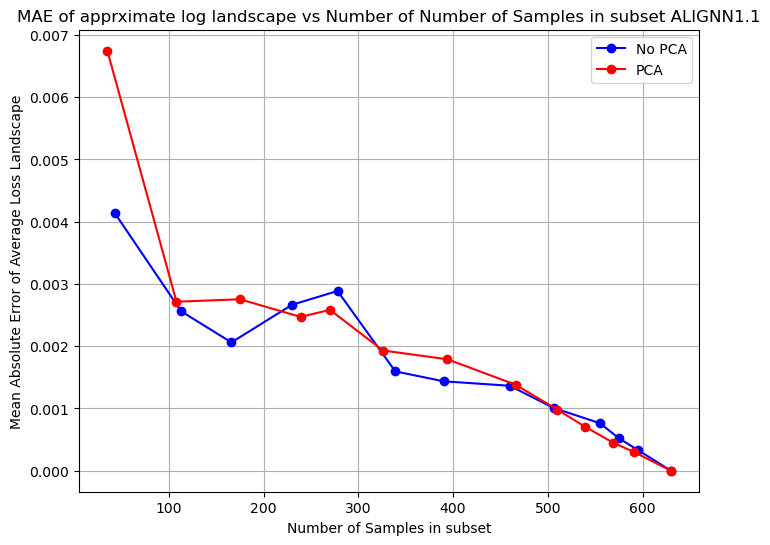

In [16]:
# Create DataFrame with results
results_df = pd.DataFrame(results_data)
results_df_pca = pd.DataFrame(results_data_pca)

# Plot n_clusters vs MAE
plt.figure(figsize=(8, 6))
plt.plot(results_df['n_samples'], results_df['mae'], 'bo-')
plt.plot(results_df_pca['n_samples'], results_df_pca['mae'], 'ro-')
plt.xlabel('Number of Samples in subset')
plt.ylabel('Mean Absolute Error of Average Loss Landscape')
plt.title('MAE of apprximate log landscape vs Number of Number of Samples in subset ALIGNN1.1')
plt.legend(['No PCA', 'PCA'])
plt.grid(True)
plt.show()


The results show minimal differences between:
1. Using PCA vs not using PCA in the algorithm
2. Using euclidean distance vs cosine similarity when selecting samples closest to cluster centroids

I just chose the simple version with no pca and euclidean distance

Visualizing if the selected subset reproduces the landscape.

In [17]:
from util.plot import plot_loss_landscape


In [18]:
# Example usage:
selected_idxs, L_full, L_approx, mae_val, n_clusters = approximate_subset_auto_k(
    samples, n_clusters=330,
                              mae_threshold=1e-5,
                              max_iters=5000,
                              random_state=0, distance_metric='norm')
print(f"Selected {len(selected_idxs)} samples; final MAE = {mae_val:.5f}")
# Assume L_full and L_approx are already defined in the environment
# and plot_loss_landscape is available.


c:\Users\EthanH24\anaconda3\envs\testing_LL_share\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Selected 390 samples; final MAE = 0.00144


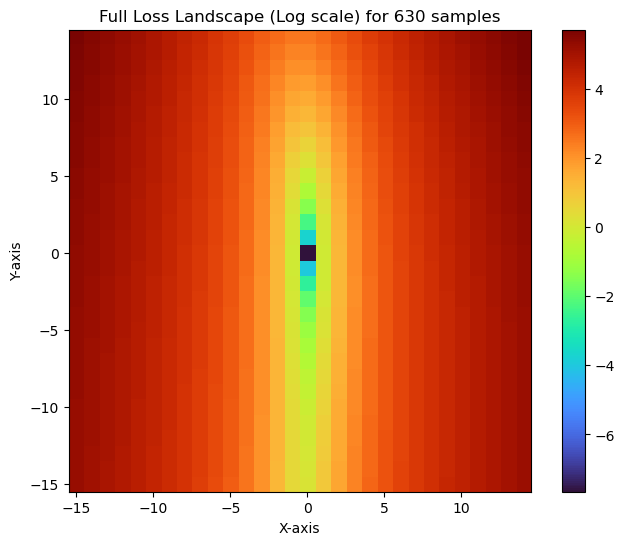

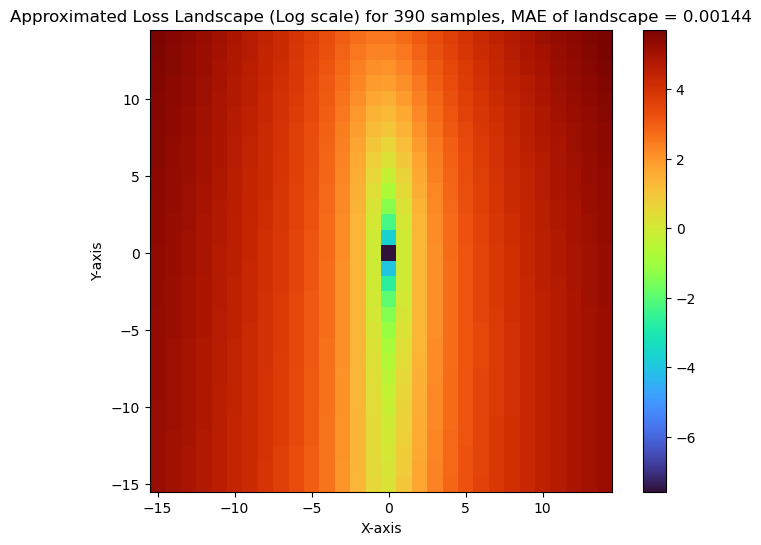

In [19]:

# Plot the full loss landscape
plot_loss_landscape(L_full, title=f'Full Loss Landscape (Log scale) for {len(landscape_array_1)} samples')

# Plot the approximated loss landscape 
plot_loss_landscape(L_approx, title=f'Approximated Loss Landscape (Log scale) for {len(selected_idxs)} samples, MAE of landscape = {mae_val:.5f}')